In [1]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
!pip install -q pyyaml h5py  # Required to save models in HDF5 format
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import preprocessing;
import math, time, itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import h5py
import requests
import os
from sklearn import linear_model;
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas_datareader import data
import urllib.request, json
import tensorflow as tf 
import io
import pdb
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# Company_select='GOOG'
Company_select='FORD MOTOR CO'
ticker_symbol='F'

In [213]:
df1 = pd.read_csv('drive/MyDrive/F.csv') #For ford
#df1 = pd.read_csv('drive/MyDrive/AMZN.csv') #For amazon
Df1_comp = df1

In [83]:
Df1_comp.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1972-06-01,0.000000,2.173495,2.149165,2.153220,0.276017,1091238
1,1972-06-02,2.153220,2.173495,2.141055,2.149165,0.275497,1174468
2,1972-06-05,2.149165,2.169440,2.141055,2.149165,0.275497,5209582
3,1972-06-06,2.149165,2.157275,2.116725,2.124835,0.272378,1424158
4,1972-06-07,2.124835,2.137000,2.112670,2.112670,0.270819,675088


In [65]:
Df1_comp.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
12483,2021-11-30,19.620001,19.950001,19.030001,19.190001,19.190001,103238400
12484,2021-12-01,19.629999,20.469999,19.530001,19.580000,19.580000,125295600
12485,2021-12-02,19.500000,20.110001,19.280001,19.870001,19.870001,94142300
12486,2021-12-03,20.370001,20.400000,18.930000,19.139999,19.139999,120139100
12487,2021-12-06,19.230000,19.490000,18.610001,19.219999,19.219999,88067000


In [131]:
Df1_comp=Df1_comp.rename(columns={"Data Date - Dividends": "Date","Trading Volume - Daily": "Volume","Price - Close - Daily": "Close","Price - High - Daily": "High","Price - Low - Daily": "Low","Price - Open - Daily": "Open","Current EPS": "Current_EPS"})
date_val=[]
#del Df1_comp["Adj Close"]
Df1_comp['Mid']=(Df1_comp['High']+Df1_comp['Low'])/2
Df1_comp['Date'] = pd.to_datetime(Df1_comp.Date)
Df1_comp.sort_values(by='Date',inplace=True)
Df1_comp.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Mid
0,1972-06-01,0.000000,2.173495,2.149165,2.153220,0.276017,1091238,2.161330
1,1972-06-02,2.153220,2.173495,2.141055,2.149165,0.275497,1174468,2.157275
2,1972-06-05,2.149165,2.169440,2.141055,2.149165,0.275497,5209582,2.155247
3,1972-06-06,2.149165,2.157275,2.116725,2.124835,0.272378,1424158,2.137000
4,1972-06-07,2.124835,2.137000,2.112670,2.112670,0.270819,675088,2.124835


In [85]:
cols = Df1_comp.columns.tolist()
cols

['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Mid']

In [68]:
#cols = ['Date', 'Volume', 'Close', 'High', 'Low', 'Open', 'Mid']

In [86]:
Df1_comp = Df1_comp[cols]
Df1_comp.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Mid
0,1972-06-01,0.000000,2.173495,2.149165,2.153220,0.276017,1091238,2.161330
1,1972-06-02,2.153220,2.173495,2.141055,2.149165,0.275497,1174468,2.157275
2,1972-06-05,2.149165,2.169440,2.141055,2.149165,0.275497,5209582,2.155247
3,1972-06-06,2.149165,2.157275,2.116725,2.124835,0.272378,1424158,2.137000
4,1972-06-07,2.124835,2.137000,2.112670,2.112670,0.270819,675088,2.124835


In [132]:
Df1_comp.drop(Df1_comp.index[0:8138], inplace=True) # for FORD

In [122]:
Df1_comp

,Date,Open,High,Low,Close,Adj Close,Volume,Mid
8138,2004-08-27,14.020000,14.180000,13.980000,14.120000,8.787968,6334100,14.080000
8139,2004-08-30,14.080000,14.090000,13.920000,13.960000,8.688389,3863200,14.005000
8140,2004-08-31,14.050000,14.150000,13.890000,14.110000,8.781744,6921200,14.020000
8141,2004-09-01,14.120000,14.130000,13.860000,13.900000,8.651046,11151600,13.995000
8142,2004-09-02,13.930000,14.400000,13.900000,14.360000,8.937340,9806700,14.150000
...,...,...,...,...,...,...,...,...
12483,2021-11-30,19.620001,19.950001,19.030001,19.190001,19.190001,103238400,19.490001
12484,2021-12-01,19.629999,20.469999,19.530001,19.580000,19.580000,125295600,20.000000
12485,2021-12-02,19.500000,20.110001,19.280001,19.870001,19.870001,94142300,19.695001
12486,2021-12-03,20.370001,20.400000,18.930000,19.139999,19.139999,120139100,19.665000


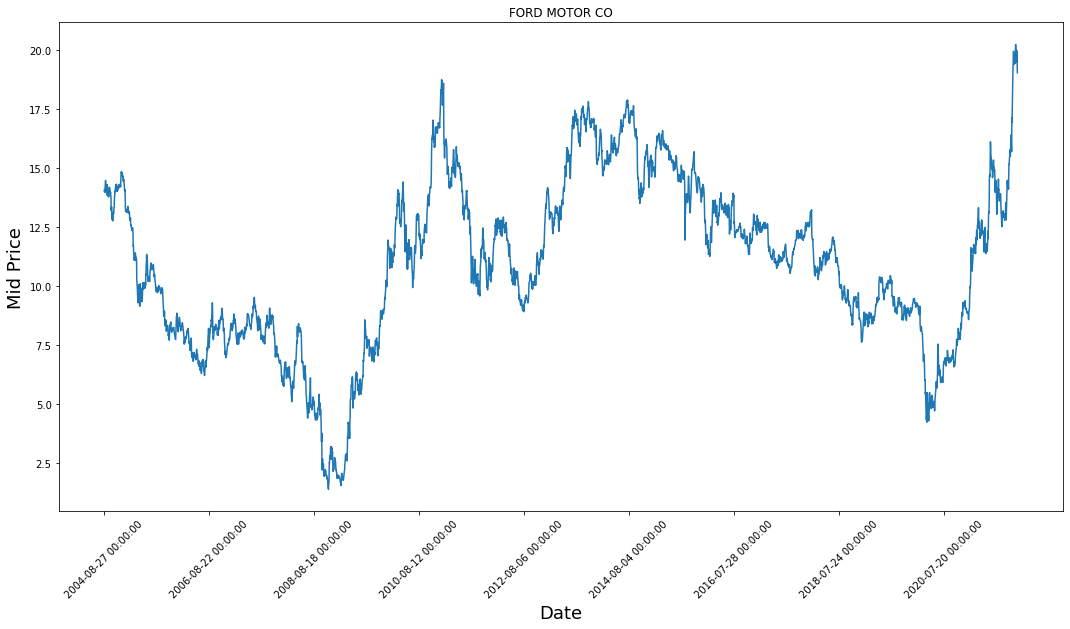

In [133]:
n = Df1_comp.shape[0]
p = Df1_comp.shape[1]
plt.figure(figsize = (18,9))
plt.plot(range(Df1_comp.shape[0]),Df1_comp['Mid'])
plt.xticks(range(0,Df1_comp.shape[0],500),Df1_comp['Date'].loc[::500],rotation=45)

plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.title(Company_select)
plt.show()

In [134]:
Df1_comp['Moving_av']= Df1_comp['Adj Close'].rolling(window=50,min_periods=0).mean()

In [97]:
Df1_comp

,Date,Open,High,Low,Close,Adj Close,Volume,Mid,Moving_av
8138,2004-08-27,14.020000,14.180000,13.980000,14.120000,8.787968,6334100,14.080000,8.787968
8139,2004-08-30,14.080000,14.090000,13.920000,13.960000,8.688389,3863200,14.005000,8.738179
8140,2004-08-31,14.050000,14.150000,13.890000,14.110000,8.781744,6921200,14.020000,8.752700
8141,2004-09-01,14.120000,14.130000,13.860000,13.900000,8.651046,11151600,13.995000,8.727287
8142,2004-09-02,13.930000,14.400000,13.900000,14.360000,8.937340,9806700,14.150000,8.769297
...,...,...,...,...,...,...,...,...,...
12483,2021-11-30,19.620001,19.950001,19.030001,19.190001,19.190001,103238400,19.490001,16.852305
12484,2021-12-01,19.629999,20.469999,19.530001,19.580000,19.580000,125295600,20.000000,16.989785
12485,2021-12-02,19.500000,20.110001,19.280001,19.870001,19.870001,94142300,19.695001,17.123911
12486,2021-12-03,20.370001,20.400000,18.930000,19.139999,19.139999,120139100,19.665000,17.233884


In [135]:
i=1
rate_increase_in_vol=[0]
rate_increase_in_adj_close=[0]
while i<len(Df1_comp):
    rate_increase_in_vol.append(Df1_comp.iloc[i]['Volume']-Df1_comp.iloc[i-1]['Volume'])
    rate_increase_in_adj_close.append(Df1_comp.iloc[i]['Adj Close']-Df1_comp.iloc[i-1]['Adj Close'])
    i+=1
    
Df1_comp['Increase_in_vol']=rate_increase_in_vol
Df1_comp['Increase_in_adj_close']=rate_increase_in_adj_close

In [100]:
Df1_comp

,Date,Open,High,Low,Close,Adj Close,Volume,Mid,Moving_av,Increase_in_vol,Increase_in_adj_close
8138,2004-08-27,14.020000,14.180000,13.980000,14.120000,8.787968,6334100,14.080000,8.787968,0,0.000000
8139,2004-08-30,14.080000,14.090000,13.920000,13.960000,8.688389,3863200,14.005000,8.738179,-2470900,-0.099579
8140,2004-08-31,14.050000,14.150000,13.890000,14.110000,8.781744,6921200,14.020000,8.752700,3058000,0.093355
8141,2004-09-01,14.120000,14.130000,13.860000,13.900000,8.651046,11151600,13.995000,8.727287,4230400,-0.130698
8142,2004-09-02,13.930000,14.400000,13.900000,14.360000,8.937340,9806700,14.150000,8.769297,-1344900,0.286294
...,...,...,...,...,...,...,...,...,...,...,...
12483,2021-11-30,19.620001,19.950001,19.030001,19.190001,19.190001,103238400,19.490001,16.852305,34459700,-0.479999
12484,2021-12-01,19.629999,20.469999,19.530001,19.580000,19.580000,125295600,20.000000,16.989785,22057200,0.389999
12485,2021-12-02,19.500000,20.110001,19.280001,19.870001,19.870001,94142300,19.695001,17.123911,-31153300,0.290001
12486,2021-12-03,20.370001,20.400000,18.930000,19.139999,19.139999,120139100,19.665000,17.233884,25996800,-0.730002


# **STEP 1**

In [108]:
def prepare_data(df,forecast_col,forecast_out,test_size):
   
    label = df[forecast_col].shift(-forecast_out);
    X = np.array(df[[forecast_col]]); 
    X = preprocessing.scale(X) 
    X_lately = X[-forecast_out:] 
    X = X[:-forecast_out] 
    label.dropna(inplace=True); 
    y = np.array(label) 
    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, y, test_size=test_size) #cross validation 

    response = [X_train,X_test , Y_train, Y_test , X_lately];
    return response;

1.6055369526319885
The test score is:  0.8699748652448098


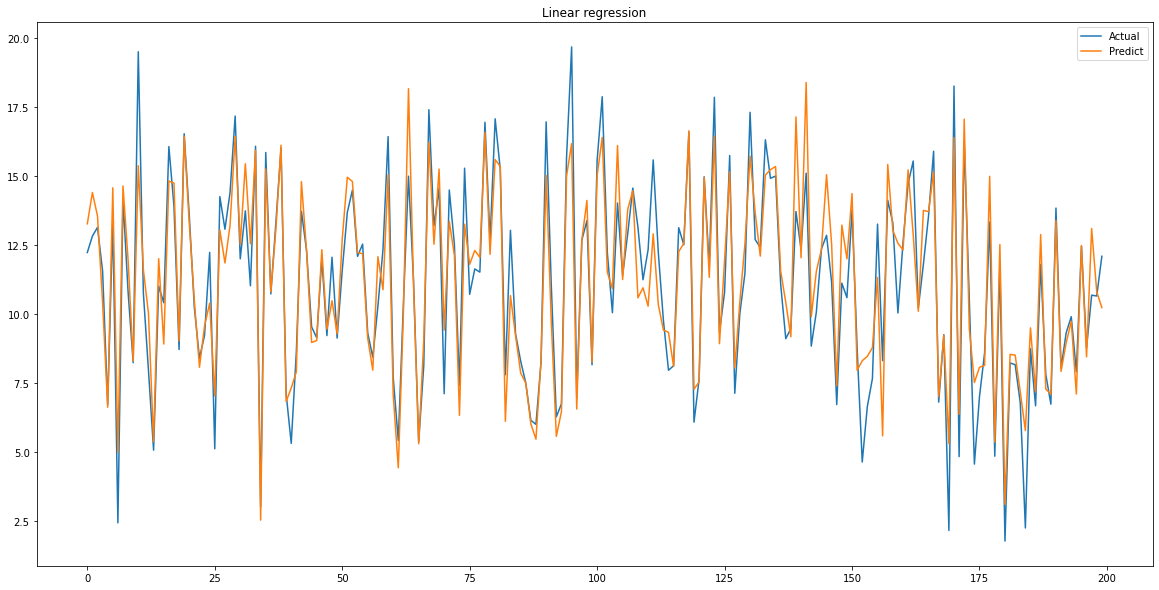

In [126]:
from sklearn.metrics import mean_squared_error
forecast_col = 'Mid'
forecast_out = 30
test_size = 0.2; 

X_train, X_test, Y_train, Y_test , X_lately =prepare_data(Df1_comp,forecast_col,forecast_out,test_size); 

learner = linear_model.LinearRegression(); 

learner.fit(X_train,Y_train);
score=learner.score(X_test,Y_test);
predicted = learner.predict(X_test)
print(mean_squared_error(Y_test,predicted))
forecast= learner.predict(X_lately); 

response={};
response['test_score']=score; 
response['forecast_set']=forecast;
print("The test score is: ",format(score))

fig = plt.figure(figsize=(20,10))
ax = plt.subplot(111)
ax.plot(Y_test[:200],label='Actual')
ax.plot(predicted[:200],label='Predict')
plt.title('Linear regression')
ax.legend()


Score: 0.8696729634943866
Mean Squared Error (MSE): 1.5608083503839756


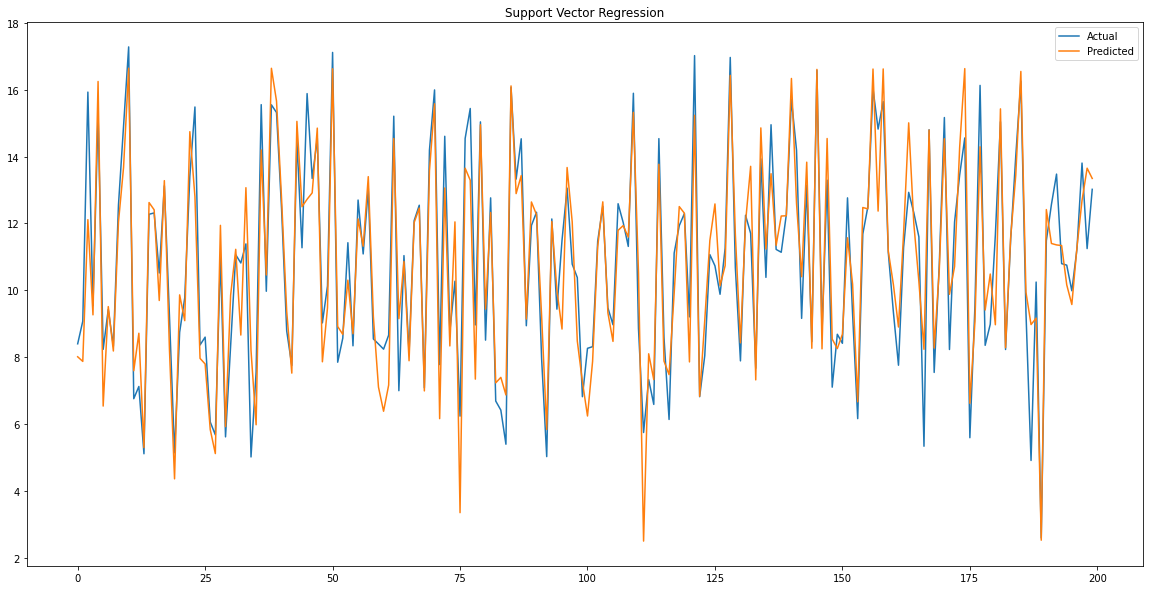

In [115]:
from sklearn.svm import SVR
regressor = SVR(kernel='rbf')
regressor.fit(X_train,Y_train)
y_pred = regressor.predict(X_test)
score=regressor.score(X_test,Y_test)
print("Score:", score)
from sklearn.metrics import mean_squared_error
print("Mean Squared Error (MSE):",mean_squared_error(Y_test, y_pred))
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(111)
ax.plot(Y_test[:200], label='Actual')
ax.plot(y_pred[:200], label='Predicted')
plt.title('Support Vector Regression')
ax.legend()

Score: 0.8734908566103012
MSE: 1.4687553690754358


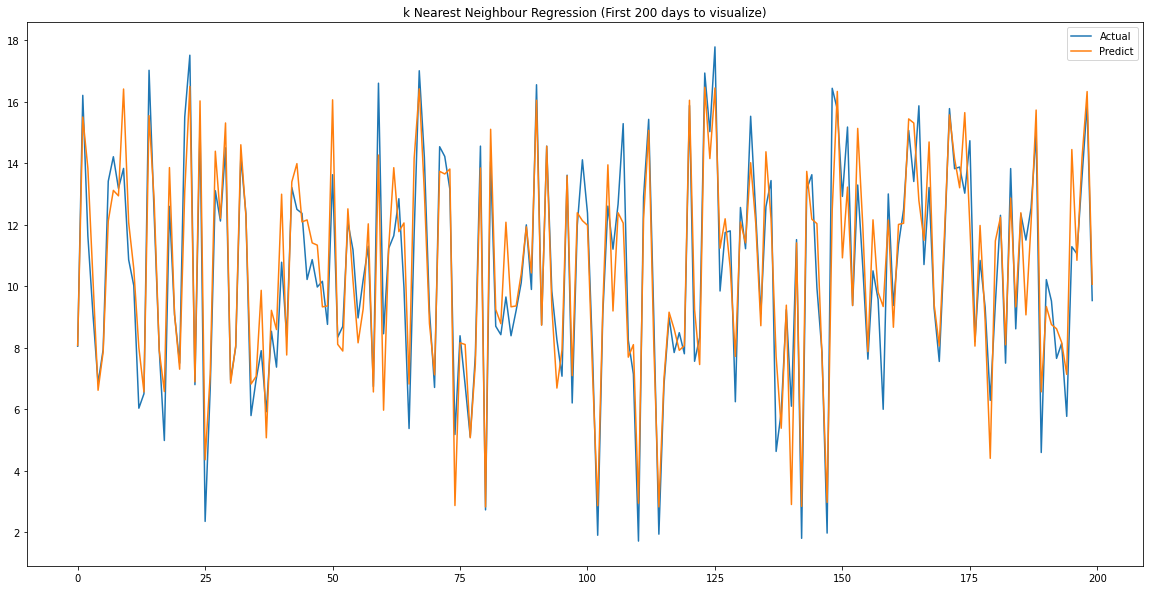

In [104]:
from sklearn import neighbors
model = neighbors.KNeighborsRegressor(n_neighbors = 80)
model.fit(X_train, Y_train)  #fit the model
pred=model.predict(X_test) #make prediction on test set
score=model.score(X_test,Y_test)
print("Score:", score)
from sklearn.metrics import mean_squared_error
print("MSE:",mean_squared_error(Y_test, pred))
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(111)
ax.plot(Y_test[:200],label='Actual')
ax.plot(pred[:200],label='Predict')
plt.title('k Nearest Neighbour Regression (First 200 days to visualize)')
ax.legend()

Score: 0.8754082693701175
MSE: 1.4921218096410536


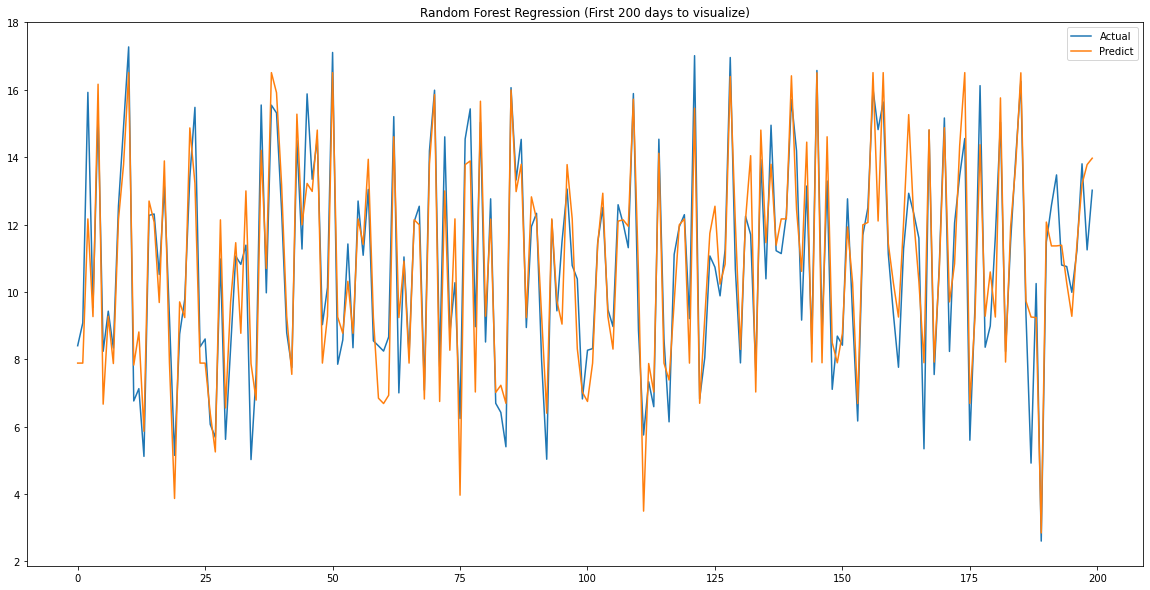

In [112]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=5, random_state=0)
regr.fit(X_train, Y_train)
pred=regr.predict(X_test) #make prediction on test set
score=regr.score(X_test,Y_test)
print("Score:", score)
from sklearn.metrics import mean_squared_error
print("MSE:",mean_squared_error(Y_test, pred))
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(111)
ax.plot(Y_test[:200],label='Actual')
ax.plot(pred[:200],label='Predict')
plt.title('Random Forest Regression (First 200 days to visualize)')
ax.legend()

In [137]:
Df1_comp

,Date,Open,High,Low,Close,Adj Close,Volume,Mid,Moving_av,Increase_in_vol,Increase_in_adj_close
8138,2004-08-27,14.020000,14.180000,13.980000,14.120000,8.787968,6334100,14.080000,8.787968,0,0.000000
8139,2004-08-30,14.080000,14.090000,13.920000,13.960000,8.688389,3863200,14.005000,8.738179,-2470900,-0.099579
8140,2004-08-31,14.050000,14.150000,13.890000,14.110000,8.781744,6921200,14.020000,8.752700,3058000,0.093355
8141,2004-09-01,14.120000,14.130000,13.860000,13.900000,8.651046,11151600,13.995000,8.727287,4230400,-0.130698
8142,2004-09-02,13.930000,14.400000,13.900000,14.360000,8.937340,9806700,14.150000,8.769297,-1344900,0.286294
...,...,...,...,...,...,...,...,...,...,...,...
12483,2021-11-30,19.620001,19.950001,19.030001,19.190001,19.190001,103238400,19.490001,16.852305,34459700,-0.479999
12484,2021-12-01,19.629999,20.469999,19.530001,19.580000,19.580000,125295600,20.000000,16.989785,22057200,0.389999
12485,2021-12-02,19.500000,20.110001,19.280001,19.870001,19.870001,94142300,19.695001,17.123911,-31153300,0.290001
12486,2021-12-03,20.370001,20.400000,18.930000,19.139999,19.139999,120139100,19.665000,17.233884,25996800,-0.730002


In [138]:
y=Df1_comp["Mid"]

In [140]:
del Df1_comp["Mid"]

In [158]:
Df1_comp

,Date,Open,High,Low,Close,Adj Close,Volume,Moving_av,Increase_in_vol,Increase_in_adj_close
8138,2004-08-27,14.020000,14.180000,13.980000,14.120000,8.787968,6334100,8.787968,0,0.000000
8139,2004-08-30,14.080000,14.090000,13.920000,13.960000,8.688389,3863200,8.738179,-2470900,-0.099579
8140,2004-08-31,14.050000,14.150000,13.890000,14.110000,8.781744,6921200,8.752700,3058000,0.093355
8141,2004-09-01,14.120000,14.130000,13.860000,13.900000,8.651046,11151600,8.727287,4230400,-0.130698
8142,2004-09-02,13.930000,14.400000,13.900000,14.360000,8.937340,9806700,8.769297,-1344900,0.286294
...,...,...,...,...,...,...,...,...,...,...
12483,2021-11-30,19.620001,19.950001,19.030001,19.190001,19.190001,103238400,16.852305,34459700,-0.479999
12484,2021-12-01,19.629999,20.469999,19.530001,19.580000,19.580000,125295600,16.989785,22057200,0.389999
12485,2021-12-02,19.500000,20.110001,19.280001,19.870001,19.870001,94142300,17.123911,-31153300,0.290001
12486,2021-12-03,20.370001,20.400000,18.930000,19.139999,19.139999,120139100,17.233884,25996800,-0.730002


In [159]:
y.shape

(4350,)

In [184]:
Df1_comp.shape

(4350, 9)

In [166]:
del Df1_comp["Date"]

In [201]:
df_train=Df1_comp[:2200]
df_target=y[:2200]

In [202]:
sc = MinMaxScaler(feature_range = (0, 1))
target_set=df_target.values.reshape(-1,1)
train_set=df_train.values
training_set_scaled = sc.fit_transform(train_set)
target_set_scaled = sc.fit_transform(target_set)

In [203]:
X_train = []
y_train = []
for i in range(50,len(train_set)):
    X_train.append(training_set_scaled[i-50:i,:])
    y_train.append(target_set_scaled[i,:])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [204]:
X_train.shape

(2150, 50, 9)

In [205]:
y_train.shape

(2150, 1)

# **LSTM**

In [211]:
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import BatchNormalization
import datetime as dt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

mod=Sequential()
mod.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1], 9)))
mod.add(Dropout(0.2))
mod.add(BatchNormalization())
mod.add(LSTM(units = 64, return_sequences = True))
mod.add(Dropout(0.1))
mod.add(BatchNormalization())
   
mod.add((LSTM(units = 64)))
mod.add(Dropout(0.1))
mod.add(BatchNormalization())
mod.add((Dense(units = 16, activation='tanh')))
mod.add(BatchNormalization())
mod.add((Dense(units = 4, activation='tanh')))
mod.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
mod.fit(X_train, y_train, epochs = 20, batch_size = 32)
    


Epoch 1/20
68/68 [==============================] - 11s 81ms/step - loss: 0.2625 - mean_squared_error: 0.2625
Epoch 2/20
68/68 [==============================] - 6s 81ms/step - loss: 0.0606 - mean_squared_error: 0.0606
Epoch 3/20
68/68 [==============================] - 6s 83ms/step - loss: 0.0190 - mean_squared_error: 0.0190
Epoch 4/20
68/68 [==============================] - 5s 80ms/step - loss: 0.0109 - mean_squared_error: 0.0109
Epoch 5/20
68/68 [==============================] - 6s 82ms/step - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 6/20
68/68 [==============================] - 6s 82ms/step - loss: 0.0093 - mean_squared_error: 0.0093
Epoch 7/20
68/68 [==============================] - 5s 80ms/step - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 8/20
68/68 [==============================] - 6s 82ms/step - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 9/20
68/68 [==============================] - 6s 81ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 10/20
68/68 